In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt  # Add this import for plotting

import os
import time

torch.manual_seed(2025)
np.random.seed(2025)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data preparation
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

print(trainset.classes)

# Method 2: Check the mapping between class names and indices
print(trainset.class_to_idx)

# Use the entire training set without validation split
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Modified ResNet18 with dropout and reduced width
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(0.2)  # Add dropout layer

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)  # Apply dropout
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, width_multiplier=1.0, num_classes=10):
        super(ResNet, self).__init__()
        self.width_multiplier = width_multiplier
        self.in_planes = int(64 * width_multiplier)

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, int(64 * width_multiplier), num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, int(128 * width_multiplier), num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, int(256 * width_multiplier), num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, int(512 * width_multiplier), num_blocks[3], stride=2)
        self.linear = nn.Linear(int(512 * width_multiplier) * block.expansion, num_classes)
        self.dropout = nn.Dropout(0.5)  # Add final dropout layer

        # Print model parameter count
        self.count_parameters()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)  # Apply dropout before final layer
        out = self.linear(out)
        return out

    def count_parameters(self):
        """Count and print the number of parameters in the model"""
        total_params = sum(p.numel() for p in self.parameters())
        print(f'Total parameters: {total_params:,}')
        return total_params

def ResNet18_Small(width_multiplier=0.5):
    return ResNet(BasicBlock, [2, 2, 2, 2], width_multiplier=width_multiplier)

# Model setup
print('==> Building model..')
net = ResNet18_Small(width_multiplier=0.665)  # Using half width to reduce parameters

if device == 'cpu':
    summary(net, (3, 32, 32))
else:
    # If using cuda, you need to move the model to GPU first
    net = net.to(device)
    summary(net, (3, 32, 32), device=device)


net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# Resume from checkpoint if needed
if os.path.isdir('checkpoint'):
    try:
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load('./checkpoint/ckpt.pth')
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
    except:
        print('No checkpoint found or error loading checkpoint')

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)

# Set number of epochs
num_epochs = 100

# Create scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, total_steps=num_epochs*len(trainloader),
    pct_start=0.3, anneal_strategy='cos'
)

# Training function
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Move scheduler step inside the batch loop

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(trainloader):
            print(f'Train Epoch: {epoch} [{batch_idx+1}/{len(trainloader)}] '
                  f'Loss: {train_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.*correct/total:.3f}% ({correct}/{total})')

    return train_loss/len(trainloader), 100.*correct/total

# Testing function
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f'Test Loss: {test_loss/len(testloader):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')

    # Save checkpoint if test accuracy is better
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

    return test_loss/len(testloader), acc

def testModel():
    net.eval()
    predictions = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

# Function to plot metrics


# Lists to store metrics
train_losses = []
train_accs = []
test_losses = []
test_accs = []
epoch_list = []

# Early stopping parameters
patience = 10
early_stop_counter = 0
best_test_loss = float('inf')

# Training loop with early stopping and metrics tracking
for epoch in range(start_epoch, start_epoch + num_epochs):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    epoch_list.append(epoch)

    # Save metrics to CSV after each epoch
    metrics_df = pd.DataFrame({
        'epoch': epoch_list,
        'train_loss': train_losses,
        'train_accuracy': train_accs,
        'test_loss': test_losses,
        'test_accuracy': test_accs
    })
    metrics_df.to_csv('training_metrics.csv', index=False)

    # Early stopping logic (using test loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

# Load the best model
print('==> Loading best model..')
checkpoint = torch.load('./checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])


# Final evaluation
print('==> Final evaluation on test set:')
test_loss, test_acc = test(0)
print(f'Best test accuracy: {best_acc:.2f}%')
print(f'Final test accuracy: {test_acc:.2f}%')

# For generating submissions on unlabeled test data

Using device: cuda
==> Preparing data..


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
==> Building model..
Total parameters: 4,929,193
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,134
       BatchNorm2d-2           [-1, 42, 32, 32]              84
            Conv2d-3           [-1, 42, 32, 32]          15,876
       BatchNorm2d-4           [-1, 42, 32, 32]              84
            Conv2d-5           [-1, 42, 32, 32]          15,876
       BatchNorm2d-6           [-1, 42, 32, 32]              84
           Dropout-7           [-1, 42, 32, 32]               0
        BasicBlock-8           [-1, 42, 32, 32]               0
         

<ipython-input-1-47a878e4c6e4>:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoint/ckpt.pth')


Test Loss: 0.677 | Acc: 93.790% (9379/10000)
Best test accuracy: 93.79%
Final test accuracy: 93.79%


Metrics plot saved as training_metrics.png


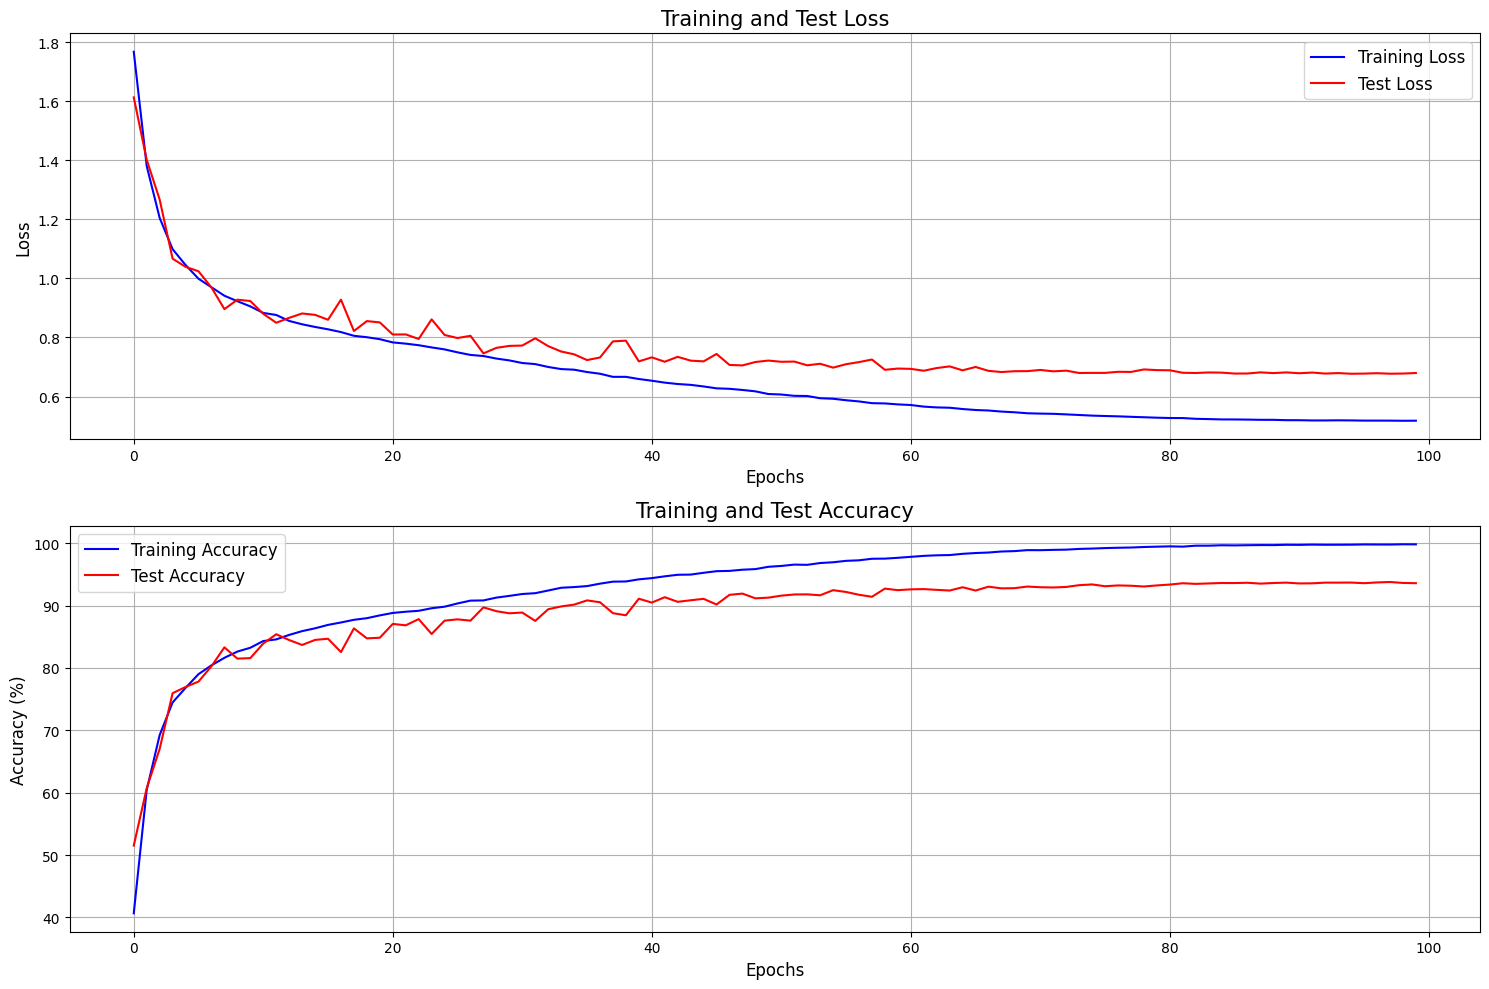

In [2]:
def plot_metrics(train_losses, train_accs, test_losses, test_accs, epochs):
    plt.figure(figsize=(15, 10))

    # Plot training & test loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Training and Test Loss', fontsize=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    # Plot training & test accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, test_accs, 'r-', label='Test Accuracy')
    plt.title('Training and Test Accuracy', fontsize=15)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    print('Metrics plot saved as training_metrics.png')
    plt.show()

  # Plot the training and testing metrics
plot_metrics(train_losses, train_accs, test_losses, test_accs, epoch_list)


In [5]:

try:
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    test = unpickle("cifar_test_nolabel.pkl")
    test_images = test[b'data'].astype(np.float32) / 255.0
    # test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  #DO NOT NEED THIS

    # Convert test dataset to Tensor
    test_dataset = [(transform_test(img)) for img in test_images]

    # Create a loader for the unlabeled test data
    unlabeled_testloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=100, shuffle=False, num_workers=2)

    # Generate predictions for unlabeled test data
    net.eval()
    predictions = []
    with torch.no_grad():
        for batch_idx, inputs in enumerate(unlabeled_testloader):
            inputs = inputs.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved.")
except Exception as e:
    print("Couldn't find the unlabeled test file. Skipping submission generation.")
    print(e)

Submission file saved.
